# SARII

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import fastai.basics as fai
import fastai.text as ftxt
import pandas as pd
import numpy as np

In [3]:
import PIL
import textwrap
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

In [5]:
!pip install autocorrect

     |████████████████████████████████| 1.8 MB 30.2 MB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-1.1.0-py3-none-any.whl size=1810765 sha256=60d7d6aa2ce99b64ecb35d97a4fad8fe4d6af99e8cc56e5c57d49d22e53a7d53
  Stored in directory: /root/.cache/pip/wheels/90/36/07/189583e2a4285fd6c41b0a80d94d14ac0bb93a33c20d4ad3ed
Successfully built autocorrect


In [6]:
import urllib.request
from wasabi import msg
from autocorrect import Speller

In [8]:
import random
import os
import glob
import matplotlib.pyplot as plt

In [9]:
import spacy
from collections import Counter
from string import punctuation
from spacy import displacy

## Data

In [10]:
df = pd.read_csv('allquotes.csv',header=None, names=['quote', 'author'])
df = df.drop(['author'], axis=1)
df = df.dropna()

In [11]:
df.head()

,quote
0,“Do one thing every day that scares you.”
1,"“We are what we pretend to be, so we must be c..."
2,"“When we love, we always strive to become bett..."
3,“Sometimes you wake up. Sometimes the fall kil...
4,"“Hold fast to dreams,For if dreams dieLife is ..."


In [12]:
df['quote'] = df['quote'].str.lower()

In [13]:
df.head()

,quote
0,“do one thing every day that scares you.”
1,"“we are what we pretend to be, so we must be c..."
2,"“when we love, we always strive to become bett..."
3,“sometimes you wake up. sometimes the fall kil...
4,"“hold fast to dreams,for if dreams dielife is ..."


In [14]:
valid_pct = 0.1 #validation percent
df = df.iloc[np.random.permutation(len(df))]
cut = int(valid_pct * len(df)) + 1
train_df, valid_df = df[cut:], df[:cut]

In [15]:
len(train_df), len(valid_df)

(10883, 1210)

In [16]:
data_lm = ftxt.TextLMDataBunch.from_df('data', train_df, valid_df, text_cols='quote')

## Langueaje Model

In [17]:
learn_lm = ftxt.language_model_learner(data_lm, ftxt.AWD_LSTM, pretrained=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


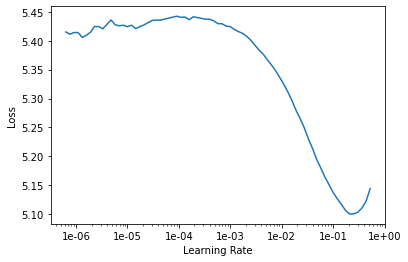

In [18]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [19]:
learn_lm.fit_one_cycle(20, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.113544,4.433343,0.215647,00:13
1,4.604181,3.936626,0.292812,00:13
2,4.255651,3.784719,0.304487,00:13
3,4.044855,3.739724,0.307857,00:13
4,3.892678,3.711860,0.311875,00:13
5,3.761450,3.706865,0.314308,00:13
6,3.657721,3.704144,0.314754,00:13
7,3.571612,3.704894,0.315960,00:13
8,3.484139,3.706311,0.316674,00:13
9,3.423049,3.709874,0.318616,00:13


In [20]:
learn_lm.save("lm-20")

In [21]:
learn_lm.save_encoder('lm-20-encoder')

In [22]:
learn_lm.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


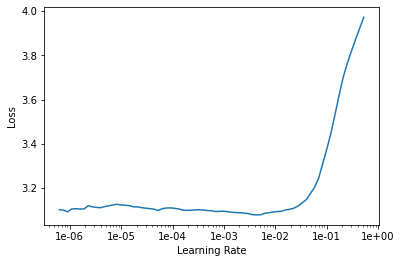

In [23]:
learn_lm.lr_find(); learn_lm.recorder.plot(skip_end=15)

In [24]:
learn_lm.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.062805,3.700403,0.323504,00:13
1,3.014246,3.698914,0.327969,00:13
2,2.926069,3.683147,0.330737,00:13
3,2.835260,3.682407,0.332701,00:13
4,2.783491,3.683534,0.333326,00:13


## Validate and Save

In [25]:
learn_lm.validate()

[3.6793144, tensor(0.3338)]

In [26]:
learn_lm.save("lm-final")

In [27]:
learn_lm.save_encoder('lm-encoder')

## Generating Quotes and Images

In [30]:
def generatequote():    
    quotes = []
    while quotes==[]:
        idea = learn_lm.predict("xxbos", n_words=24, temperature=0.75)
        ideas = idea.split("xxbos")
        if ideas[1][-1] == "”":
            quotes.append(ideas[1])
            
    message = quotes[0][:]
    message = '“'+message[3:].capitalize()
    message = message.replace(' . ','. ')
    message = message.replace(' ,',',')
    message = message.replace('’',"'")
    message = message.replace("do n't", "don't")
    message = message.replace("does n't", "doesn't")
    message = message.replace("ca n't", "can't")
    message = message.replace("we 're", "we're")
    message = message.replace(" 's", "'s")
    message = message.replace(" 've", "'ve")
    message = message.replace("you 're", "you're")
    spell = Speller()
    message = spell(message)
    msg.good("Message")
    return message[:-2]+'”'

In [31]:
def text2image(imageFile,font,quote):
    
    font = ImageFont.truetype(font, 75)

    para = textwrap.wrap(quote, width=42)

    MAX_W, MAX_H = 1080, 1080

    im = Image.open(imageFile).convert('RGBA')

    poly = Image.new('RGBA', (MAX_W,MAX_H))
    polydraw = ImageDraw.Draw(poly)

    polydraw.rectangle([(0,0),(MAX_W,MAX_H)], fill=(0,0,0,66), outline=None)
    
    im.paste(poly,mask=poly)

    draw = ImageDraw.Draw(im)

    current_h, pad = 405, 10

    for line in para:
        w, h = draw.textsize(line, font=font)
        draw.text(((MAX_W - w) / 2, current_h), line, font=font)
        current_h += h + pad
        
    current_h3, pad3 = 675, 10
    sitelink = "@SARII_bot"
    w, h = draw.textsize(sitelink, font=font)
    draw.text(((MAX_W - w) / 2, current_h3), sitelink, font=font)
    current_h3 += h + pad3

    plt.imshow(np.asarray(im))
    name = list(quote.split())[1:5]
    newfilename = "".join(name)+".png"
    finalpath = "generated/"+newfilename
    im.save(finalpath)
    msg.good("Image Saved")
    return(finalpath)

In [32]:
def downloadimage(key):
    imagepath = urllib.request.urlretrieve('https://source.unsplash.com/1080x1080/?'+str(key),"temp.jpg")[0]
    msg.good("Image Downloaded")
    return imagepath

In [33]:
def selectfont():
    fonts = []
    os.chdir("fonts")
    for file in glob.glob("*.ttf"):
        fonts.append("fonts/"+file)
    os.chdir("..")
    msg.good("Font selected")
    return random.choice(fonts)

# Extracting keys for image search

In [36]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4 MB 4.6 MB/s eta 0:00:014     |█████████▌                      | 28.7 MB 1.9 MB/s eta 0:00:37     |██████████████████████████▌     | 79.8 MB 4.4 MB/s eta 0:00:04     |█████████████████████████████▍  | 88.7 MB 6.3 MB/s eta 0:00:02
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=988d3d942970dfe14adb400fda00c3e07845df2e482694d41f02c23608d473f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-942hyawf/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [37]:
!python -m spacy validate

✔ Loaded compatibility table

====================== Installed models (spaCy v2.2.3) ======================
ℹ spaCy installation:
/opt/conda/envs/fastai/lib/python3.7/site-packages/spacy

TYPE      NAME             MODEL            VERSION                            
package   en-core-web-md   en_core_web_md   2.2.5   ✔



In [38]:
import en_core_web_md

In [39]:
nlp = en_core_web_md.load()

In [40]:
def get_key(text):
    result = []
    pos_tag = ['PROPN', 'ADJ', 'NOUN'] # 1
    doc = nlp(text.lower()) # 2
    for token in doc:
        # 3
        if(token.text in nlp.Defaults.stop_words or token.text in punctuation):
            continue
        # 4
        if(token.pos_ in pos_tag):
            result.append(token.text)
    msg.good("Keys Extracted")
    return list(set(result)) # 5

In [41]:
message = generatequote()
print(message)
key = get_key(message)[0]
print(key)

✔ Message
“The only way for you to see the beauty of those things, is to see the beauty of your life.”
✔ Keys Extracted
beauty


# Result

In [42]:
def generate(): 
    print('')
    message = generatequote()
    try:
        keys = get_key(message)[:3]
        key = 'landscapes'
    except:
        msg.fail("Unable to retrieve key")
    imagepath = downloadimage(key)
    selectedfont = selectfont() 
    restultimage = text2image(imagepath,selectedfont,message)
    print('')
    msg.good("Done!")
    print('')
    msg.info("Image key: "+key)
    msg.info("Selected font: "+selectedfont)
    msg.info("Image path: "+restultimage)
    print('')
    print(message+' - #SARII #AI '+''.join(['#'+str(i.capitalize())+' ' for i in keys]))
    print('')

In [50]:
!rm -R generated && mkdir generated


✔ Message
✔ Keys Extracted
✔ Image Downloaded
✔ Font selected
✔ Image Saved

✔ Done!

ℹ Image key: landscapes
ℹ Selected font: fonts/Little Miracles Demo.ttf
ℹ Image path: generated/happinessofyourpast.png

“The happiness of your past is never defined by your past, but the future is yours to fulfill your purpose.” - #SARII #AI #Happiness #Future #Past 



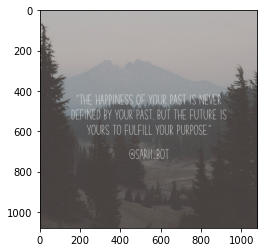

In [51]:
generate()